In [1]:
!pip install --upgrade xarray zarr gcsfs google-auth

from google.colab import auth
auth.authenticate_user()

import xarray as xr
import gcsfs


try:
    era5 = xr.open_zarr(
        "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2",
        chunks={'time': 48},
        consolidated=True
    )
    print("Dataset loaded successfully!")
    print(era5)
except Exception as e:
    print("Error loading dataset:", e)

Dataset loaded successfully!
<xarray.Dataset> Size: 534TB
Dimensions:                                           (time: 552264,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 37)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 296B 1 .....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 4MB ...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
  

In [2]:
era5

<xarray.Dataset> Size: 534TB
Dimensions:                                           (time: 552264,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 37)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 296B 1 .....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 4MB ...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    geopotential                                      (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    ...                                                ...
    total_precipitation                               (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    type_of_high_vegetation                           (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    type_of_low_vegetation                            (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u_component_of_wind                               (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind                               (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>

In [3]:
subset_temperature = era5['2m_temperature'].sel(
    latitude=[40.0, 20.0],
    longitude=280.0,
    time=slice("2020-01-01", "2021-06-30")
)

subset_temperature_computed = subset_temperature.compute()

df = subset_temperature_computed.to_dataframe().reset_index()
df.to_csv("subset_temperature.csv", index=False)

from google.colab import files
files.download("subset_temperature.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


In [6]:
df = pd.read_csv(base_path + 'subset_temperature.csv', parse_dates=['time'])
df.head()

,time,latitude,longitude,2m_temperature
0,2020-01-01 00:00:00,40.0,280.0,274.95590
1,2020-01-01 00:00:00,20.0,280.0,299.77255
2,2020-01-01 01:00:00,40.0,280.0,275.06668
3,2020-01-01 01:00:00,20.0,280.0,299.77100
4,2020-01-01 02:00:00,40.0,280.0,274.62810


In [7]:
loc1 = df[(df['latitude'] == 40.0) & (df['longitude'] == 280.0)].copy()
loc2 = df[(df['latitude'] == 20.0) & (df['longitude'] == 280.0)].copy()

loc1 = loc1.sort_values('time')
loc2 = loc2.sort_values('time')

temp_loc1 = loc1['2m_temperature'].values
temp_loc2 = loc2['2m_temperature'].values

time_loc1 = loc1['time'].values
time_loc2 = loc2['time'].values

combined_data = np.concatenate([temp_loc1, temp_loc2], axis=0)
combined_times = np.concatenate([time_loc1, time_loc2], axis=0)
combined_times = pd.to_datetime(combined_times)

In [8]:
mean_val = combined_data.mean()
std_val = combined_data.std()

temp_loc1_norm = (temp_loc1 - mean_val) / (std_val + 1e-8)
temp_loc2_norm = (temp_loc2 - mean_val) / (std_val + 1e-8)

In [9]:
split_date = datetime(2021, 1, 1)

# For location 1
mask1_train = loc1['time'] < split_date
mask1_test = loc1['time'] >= split_date
train_data_loc1 = temp_loc1_norm[mask1_train.values]
test_data_loc1 = temp_loc1_norm[mask1_test.values]
train_times_loc1 = loc1['time'].values[mask1_train.values]
test_times_loc1 = loc1['time'].values[mask1_test.values]

# For location 2
mask2_train = loc2['time'] < split_date
mask2_test = loc2['time'] >= split_date
train_data_loc2 = temp_loc2_norm[mask2_train.values]
test_data_loc2 = temp_loc2_norm[mask2_test.values]
train_times_loc2 = loc2['time'].values[mask2_train.values]
test_times_loc2 = loc2['time'].values[mask2_test.values]

train_data_combined = np.concatenate([train_data_loc1, train_data_loc2], axis=0)

In [10]:
class TemperatureDataset(Dataset):
    def __init__(self, data, seq_length=24):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        y = self.data[idx+self.seq_length]
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y

seq_length = 24
train_dataset = TemperatureDataset(train_data_combined, seq_length=seq_length)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size=1, hidden_size=64, num_layers=2).to(device)

if torch.cuda.device_count() >= 1:
    gpu_info = torch.cuda.get_device_name(0)
    print("Using", torch.cuda.device_count(), "GPUs for DataParallel")
    print(f"GPU Type: {gpu_info}")
    model = nn.DataParallel(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
import time

epochs = 5
total_start_time = time.time()  # 记录整个训练过程的开始时间

for epoch in range(epochs):
    epoch_start_time = time.time()  # 记录单个 epoch 的开始时间
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_end_time = time.time()  # 记录单个 epoch 的结束时间
    epoch_duration = epoch_end_time - epoch_start_time  # 计算单个 epoch 的持续时间

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.4f}, Duration: {epoch_duration:.2f} seconds")

total_end_time = time.time()  # 记录整个训练过程的结束时间
total_duration = total_end_time - total_start_time  # 计算整个训练过程的持续时间

print(f"Total training time: {total_duration:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/5], Train Loss: 0.1669, Duration: 9.91 seconds
Epoch [2/5], Train Loss: 0.0169, Duration: 8.70 seconds
Epoch [3/5], Train Loss: 0.0067, Duration: 10.10 seconds
Epoch [4/5], Train Loss: 0.0053, Duration: 8.00 seconds
Epoch [5/5], Train Loss: 0.0047, Duration: 9.92 seconds
Total training time: 46.64 seconds


In [14]:
test_dataset_loc1 = TemperatureDataset(test_data_loc1, seq_length=seq_length)
test_dataset_loc2 = TemperatureDataset(test_data_loc2, seq_length=seq_length)

test_loader_loc1 = DataLoader(test_dataset_loc1, batch_size=128, shuffle=False, num_workers=4)
test_loader_loc2 = DataLoader(test_dataset_loc2, batch_size=128, shuffle=False, num_workers=4)

model.eval()

def predict_and_plot(test_dataset, test_loader, test_times, location_label):
    # Generate predictions
    all_preds = []
    all_trues = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch).squeeze()
            all_preds.append(y_pred.cpu().numpy())
            all_trues.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_trues = np.concatenate(all_trues)

    # Inverse normalization
    all_preds_original = all_preds * std_val + mean_val
    all_trues_original = all_trues * std_val + mean_val

    pred_times = test_times[seq_length:]

    plt.figure(figsize=(15, 5))
    plt.plot(pred_times, all_trues_original, label='True Temperature', color='blue')
    plt.plot(pred_times, all_preds_original, label='Predicted Temperature', color='red', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.title(f'True vs. Predicted Temperature for {location_label}')
    plt.legend()
    plt.grid(True)
    plt.show()

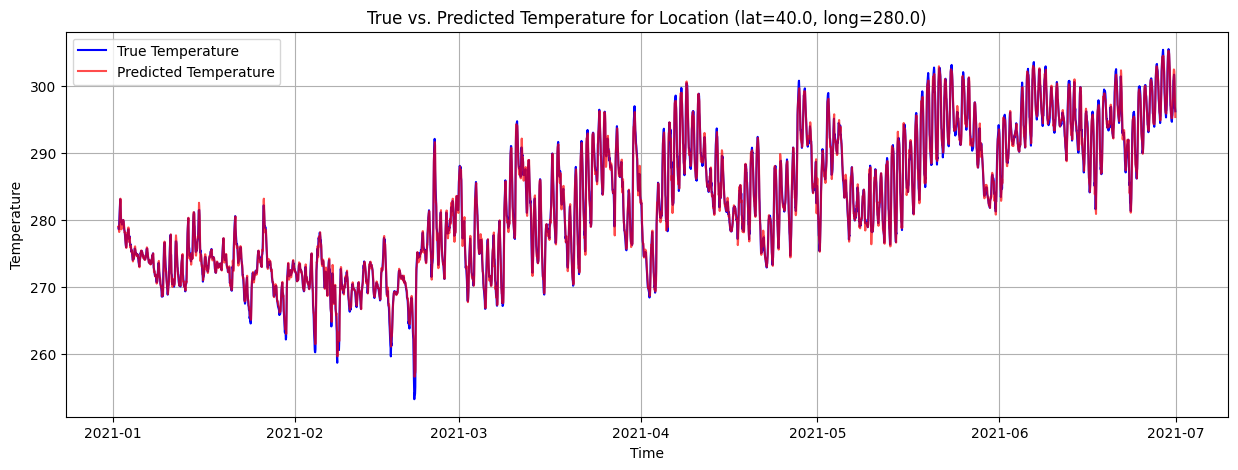

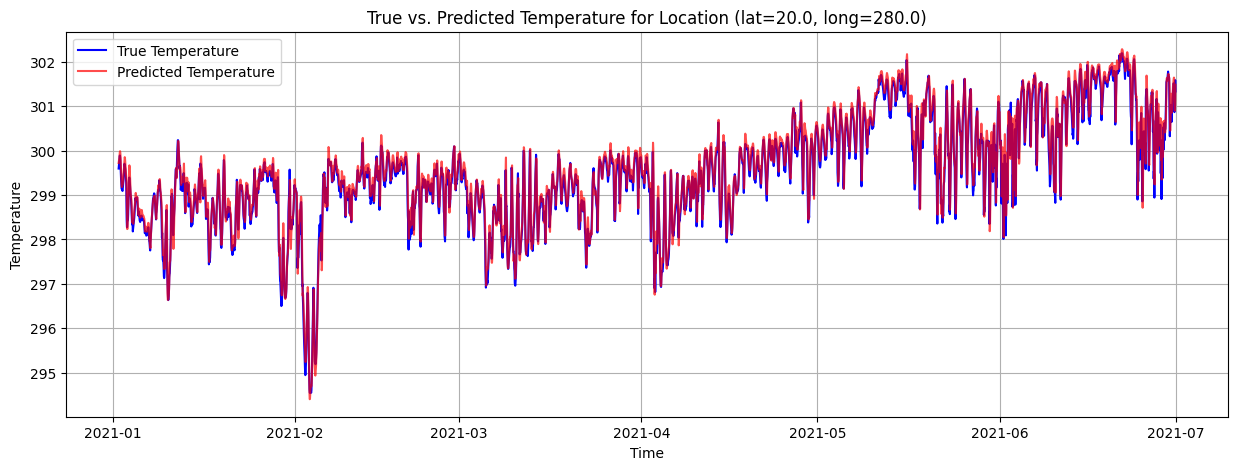

In [15]:
predict_and_plot(test_dataset_loc1, test_loader_loc1, test_times_loc1, location_label="Location (lat=40.0, long=280.0)")
predict_and_plot(test_dataset_loc2, test_loader_loc2, test_times_loc2, location_label="Location (lat=20.0, long=280.0)")